# Laboratory 3

## Preliminaries
### Configuration


In [1]:
%pip install blist

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))
            

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interface

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        self.callback = _Button_callback(scenes)
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
        
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Example

##### Simple plotting

You need to create variable with object 'Plot', which accepts as a constructor parameter list of scenes or a string with scenes in json format. Then, after adding all scenes, you need to call 'draw()'.

<IPython.core.display.Javascript object>


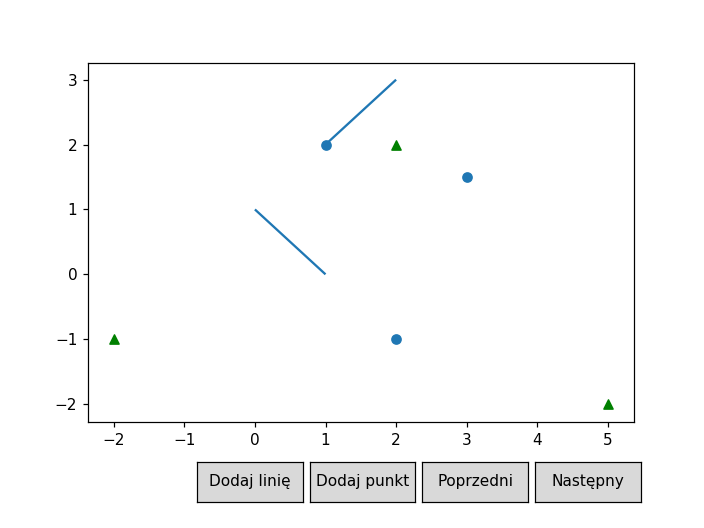

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### File read and write

Plot class has method 'toJson()', which returns string containing list of scenes in JSON format. This string can be wrote to file. Then you can use it in 'Plot' constructor.

<IPython.core.display.Javascript object>


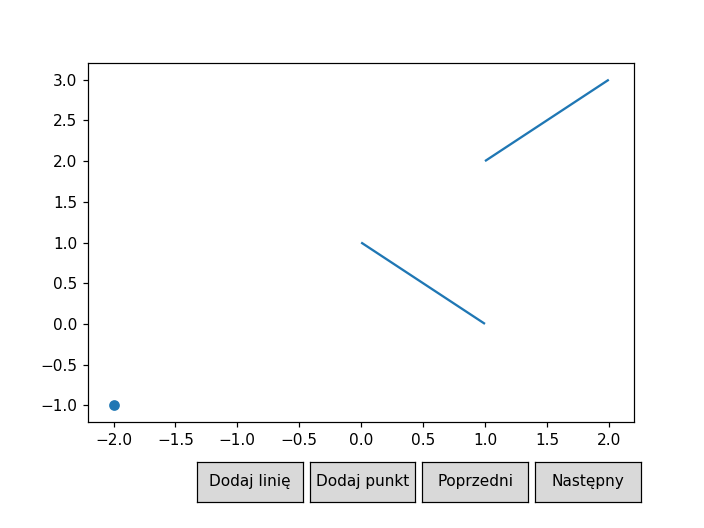

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operations on added points

One can easly draw new points and lines. It is suggested that in order to use them you create new 'Plot' in a new cell, using 'get_added_points()' and 'get_added_lines()' or 'get_added_elements()' (returns Scene) methods from former 'Plot'.

<IPython.core.display.Javascript object>


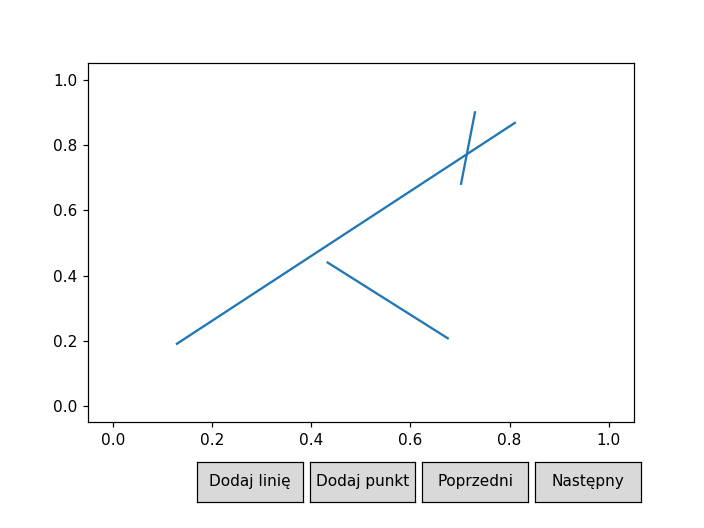

In [6]:
%matplotlib notebook

plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


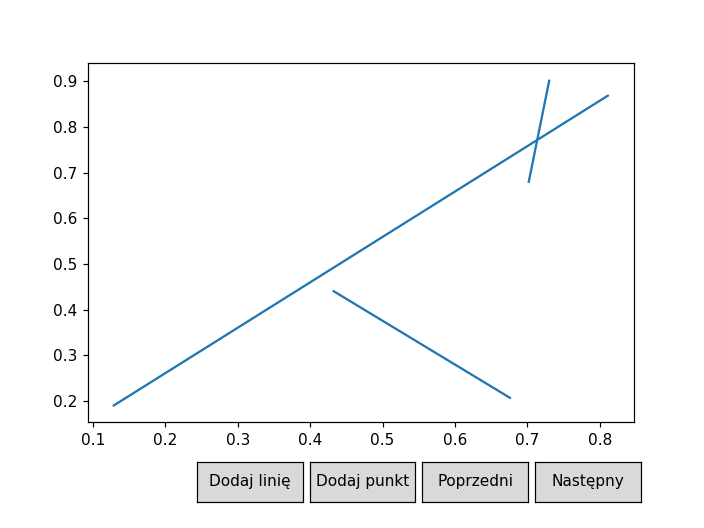

In [7]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Visualiser

In [8]:
class Visualiser:  
    def __init__(self):
        self.scenes = []
        
    def get_scenes(self):
        return self.scenes
    
    def make_starts(l):
        return [i[0] for i in l]
    
    def make_ends(l):
        return [i[1] for i in l]
    
    def put_scene(self, l, color = 'blue'):
        self.scenes.append(Scene( [ PointsCollection(Visualiser.make_starts(l), color='blue'), PointsCollection(Visualiser.make_ends(l), color='green')], 
                              [ LinesCollection(l,color=color)])) 
        
    def put_broom(self, broom):
        self.put_scene([broom[k].get_line() for k in range(len(broom))])
    
    def put_checked(self, broom, a, b):
        self.put_broom(broom)
        self.scenes[-1].lines.append(LinesCollection([a.get_line()],color='red'))
        self.scenes[-1].lines.append(LinesCollection([b.get_line()],color='red'))

## Lines generation

In [9]:
def linesCollection_to_lines(linescollection):
    res = []
    for i in linescollection:
        res = res + i.lines
    return list(map(sorted, res))

<IPython.core.display.Javascript object>


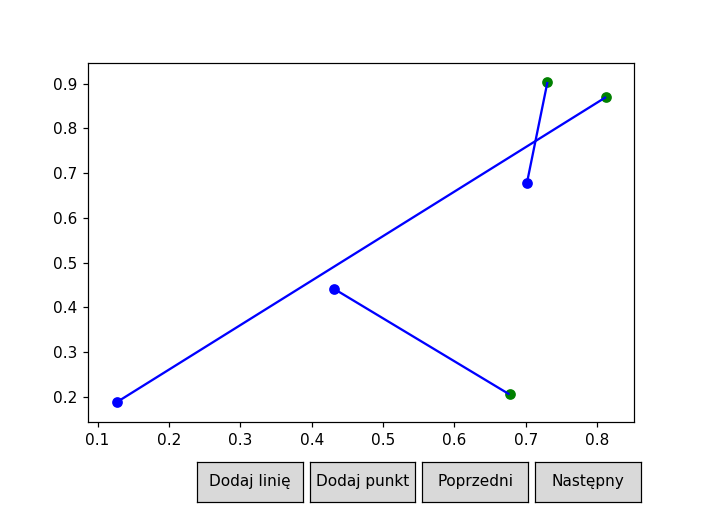

In [10]:
visualiser = Visualiser()
visualiser.put_scene(linesCollection_to_lines(plot1.get_added_lines()))
plot = Plot(visualiser.get_scenes())
plot.draw()

### Generate some segments

In [11]:
def gen_segments(number, x_low, x_high, y_low, y_high):
    from random import randint, random as rand
    res = []
    points = set()
    while number > 0:
        start = (randint(x_low,x_high),randint(y_low,y_high))
        end = (min(x_high, start[0]+(x_high-x_low)*(rand())), min(y_high, start[1]+(y_high-y_low)*(rand()) ))
        if start[0] == end[0]:
            continue
        if start in points or end in points:
            continue
        res.append([start,end])         
        points.add(start)
        points.add(end)
        number-=1
    return list(res)

In [12]:
lines = gen_segments(10,0,1000000,0,1000000)

In [13]:
print(lines)

[[(222004, 833766), (619109.7164521883, 1000000)], [(937165, 13329), (1000000, 849401.6372787241)], [(207659, 948935), (1000000, 1000000)], [(399987, 185816), (560973.7962988692, 1000000)], [(321625, 224704), (1000000, 815249.4567060509)], [(562157, 59566), (598925.3969907339, 978791.6259357595)], [(234363, 101429), (277869.913003837, 566488.1943063587)], [(878550, 545524), (1000000, 920029.5265675279)], [(348862, 61718), (859721.7356617094, 152999.1987025526)], [(253169, 803180), (265705.3091519913, 1000000)]]


In [29]:
lines = [[(430284, 776656), (552874.7465307094, 1000000)], [(370350, 52533), (605840.9595589649, 715566.9471416788)], [(315960, 875451), (1000000, 1000000)], [(1494, 296838), (891313.8452214828, 341069.0545742922)], [(273349, 325215), (1000000, 407322.34625825565)], [(225827, 570566), (538849.6344932264, 596444.9907368273)], [(94566, 647937), (801937.6734995844, 1000000)], [(896458, 59897), (1000000, 848724.967704153)], [(155611, 457104), (700367.6668720007, 1000000)], [(959135, 669108), (977978.7657396083, 1000000)]]

In [15]:
lines = [[(9.268083958092777, 23.46077956471978), (11.507469864870368, 35.60107274722949)], [(7.83953170842131, 25.806343727487658), (46.63651086038971, 24.865618452721815)], [(32.703556657493095, 34.090180681203286), (78.31183076613024, 77.99627617835448)], [(16.220183480987536, 16.568670206268788), (22.57678552273078, 11.546532100036533)], [(48.07266538977045, 66.38537473249849), (94.6410444358644, 61.33645645371416)]]

In [16]:
lines = [[(30.916613353673096, 10.960161402292135), (56.84960002003936, 17.615265863753315)], [(48.768416669228934, 49.45835255363219), (77.09177423538209, 1.8423636499499185)], [(12.507388001352648, 22.769291848599238), (20.915387145280317, 17.654566040871845)], [(41.663189169712034, 57.584493281558494), (65.47273346108439, 45.878706364069764)], [(3.337058203548937, 79.72171357947532), (34.8191955274211, 84.79324448376197)]]

<IPython.core.display.Javascript object>


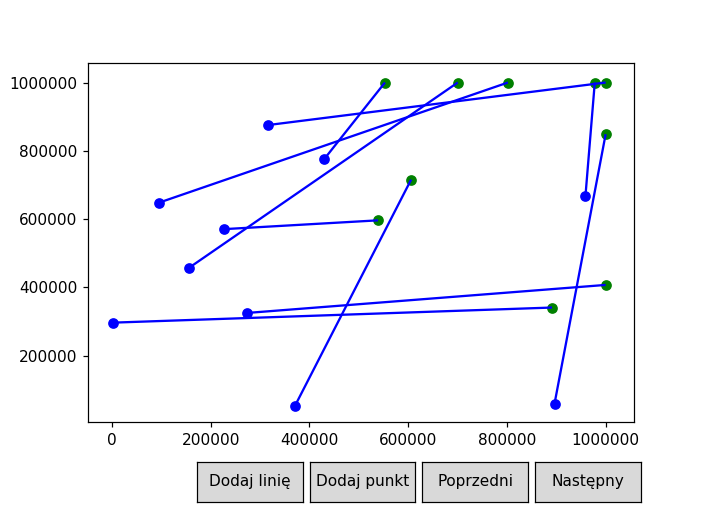

In [30]:
visualiser = Visualiser()
visualiser.put_scene(lines)
plot = Plot(visualiser.get_scenes())
plot.draw()

## Solution

### Segments intersection

In [20]:
def det(a,b,c):
    return a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-c[0]*b[1]-a[1]*b[0]-a[0]*c[1]

In [21]:
def on_segment(x,y,z):
    return min(x[0],y[0]) <= z[0] and z[0] <= max(x[0],y[0]) and min(x[1],y[1]) <= z[1] and z[1] <= max(x[1],y[1])

In [22]:
def lines_intersect(a,b):
    e=0
    p1 = a.start
    p2 = a.end
    p3 = b.start
    p4 = b.end
    d1 = det(p3,p4,p1)
    d2 = det(p3,p4,p2)
    d3 = det(p1,p2,p3)
    d4 = det(p1,p2,p4)
    
    if ((d1 > e and d2 < -e) or (d1 < -e and d2 > e)) and ((d3 > e and d4 < -e) or (d3 < -e and d4 > e)):
        return True
    if (d1 >= -e and d1 <= e) and on_segment(p3,p4,p1):
        return True
    if (d2 >= -e and d2 <= e) and on_segment(p3,p4,p2):
        return True
    if (d3 >= -e and d3 <= e) and on_segment(p1,p2,p3):
        return True
    return (d4 >= -e and d4 <= e) and on_segment(p1,p2,p4)

### Declare used structures

In [23]:
class Event:
    def __init__(self, pos, event_type, line):
        self.pos = pos
        self.event_type = event_type
        self.line = line

    def __gt__(self, other):
        if self.pos[0] == other.pos[0]:
            if self.event_type == other.event_type:
                return self.pos[1] < other.pos[1]
            return self.event_type == 'start'
        return self.pos[0] < other.pos[0]

In [24]:
class Line:
    def set_class(det,e=10**-14):
        Line.det = det
        Line.e = e
        
    def __init__(self, line):
        self.start = line[0]
        self.end = line[1]
        self.m = (self.start[1]-self.end[1])/(self.start[0]-self.end[0])
        self.b = (self.start[1]-self.m*self.start[0])
        
    def set_ordering(x):
        Line.ordering_x = x
        
    def get_line(self):
        return [self.start, self.end]

    def __eq__(self, other):
        return self.start == other.start and self.end == other.end
    
    def __gt__(self, other):
        x = Line.ordering_x
        return self.m*x+self.b > other.m*x+other.b

### Check if any two lines intersect

In [25]:
def get_Events_from_lines(lines):
    timetable = []
    for i in lines:
        l = Line(i)
        timetable.append(Event(i[0],'start',l))
        timetable.append(Event(i[1],'end',l))
    return timetable

In [26]:
def check_any(a,b,broom,visualiser=None):
    if visualiser is not None:
        visualiser.put_checked(broom,a,b)
    if lines_intersect(a,b):
        return True
    return False

def any_intersect(lines, visualiser=None, det=det, e = 10**-14):
    if visualiser is not None:
        visualiser.put_scene(lines,'deepskyblue')
        
    from blist import sortedset 
    Line.set_class(det,e)
    
    timetable = sorted(get_Events_from_lines(lines))
    broom = sortedset()

    while len(timetable) > 0:
        i = timetable.pop()
        Line.set_ordering(i.pos[0])
        if i.event_type == 'start':
            broom.add(i.line)  
            if visualiser is not None:
                visualiser.put_broom(broom)
            
            b = broom.index(i.line)
            b -= 1
            if b>=0 and b < len(broom) and check_any(broom[b], i.line,broom,visualiser):
                return True
                
            b += 2
            if b>=0 and b < len(broom) and check_any(broom[b], i.line,broom,visualiser):
                return True
        else:
            k = broom.index(i.line)
            a = k+1
            b = k-1
            if a < len(broom) and b < len(broom) and a>=0 and b>=0:
                if check_any(broom[a],broom[b],broom,visualiser):
                    return True
            
            broom.discard(i.line)            
            if visualiser is not None:
                visualiser.put_broom(broom)
                
    return False   

True


<IPython.core.display.Javascript object>


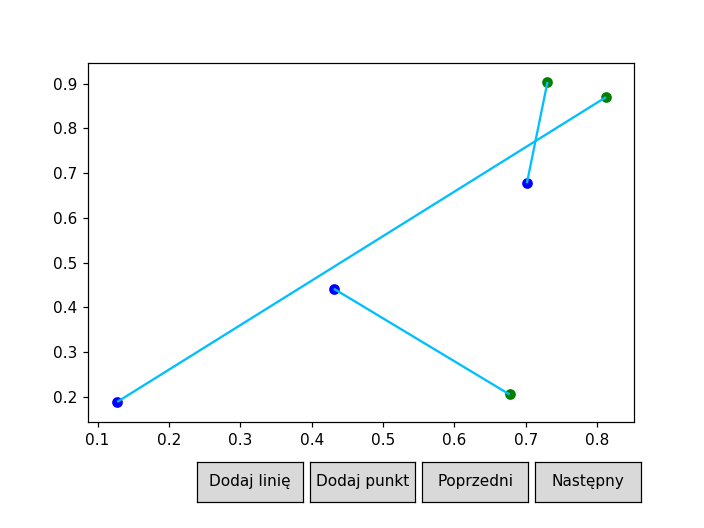

In [28]:
visualiser = Visualiser()

print(any_intersect(linesCollection_to_lines(plot1.get_added_lines()), visualiser))

plota = Plot(visualiser.get_scenes())
plota.draw()

True


<IPython.core.display.Javascript object>


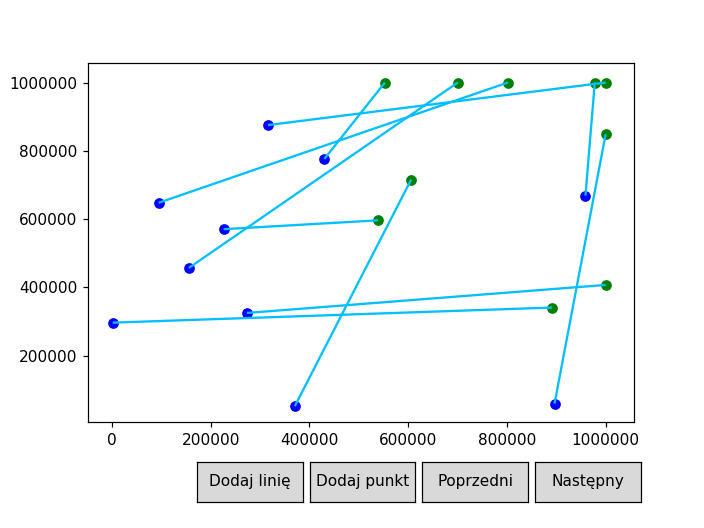

In [31]:
visualiser = Visualiser()

print(any_intersect(lines, visualiser))

plota = Plot(visualiser.get_scenes())
plota.draw()

### Find intersections

In [32]:
def get_Event_from_intersection(first,second):
    x = (second.b - first.b)/(first.m - second.m)
    intersection_point = (x,first.m*x+first.b)
    return Event(intersection_point, 'cross', [first,second])
    
def check_cross(first, second, timetable, broom, visualiser=None):
    if visualiser is not None:
        visualiser.put_checked(broom,first,second)
    if lines_intersect(first, second):
        timetable.add(get_Event_from_intersection(first, second))


In [33]:
def get_intersections(lines, visualiser = None, e=10**-14, det=det):
    if visualiser is not None:
        visualiser.put_scene(lines,'deepskyblue')
    
    from blist import sortedset, sortedlist
    Line.set_class(det,e)
    
    timetable = sortedlist(get_Events_from_lines(lines))
    broom = sortedset()
    Line.set_ordering(timetable[-1].pos[0])

    intersections = set()
    
    while len(timetable) > 0:
        i = timetable.pop()

        if i.event_type == 'start':
            Line.set_ordering(i.pos[0])
            broom.add(i.line)  
            
            if visualiser is not None:
                visualiser.put_broom(broom)
                
            b = broom.index(i.line)
            b -= 1
            if b>=0 and b < len(broom):
                check_cross(broom[b], i.line, timetable, broom, visualiser)
                
            b += 2
            if b>=0 and b < len(broom):
                check_cross(broom[b], i.line, timetable, broom, visualiser)

        elif i.event_type == 'end':
            k = broom.index(i.line)
            a = k+1
            b = k-1
            if a < len(broom) and b < len(broom) and a>=0 and b>=0:
                check_cross(broom[a], broom[b], timetable, broom, visualiser)
            broom.discard(i.line)            
            if visualiser is not None:
                visualiser.put_broom(broom)
                
        else:
            if i.pos in intersections:
                continue
            intersections.add(i.pos)
            broom.discard(i.line[0])
            broom.discard(i.line[1])
            
            Line.set_ordering(i.pos[0])            
            Line.ordering_x += 10**-5
            broom.add(i.line[0])
            broom.add(i.line[1])
            
            k = broom.index(i.line[0])
            m = broom.index(i.line[1])
            
            if k > m:
                k , m = m , k
                
            if m >= 0 and m+1 < len(broom) and m+1 != k:
                check_cross(broom[m],broom[m+1],timetable, broom, visualiser)
            if k-1 >= 0 and k < len(broom) and k-1 != m:
                check_cross(broom[k],broom[k-1],timetable, broom, visualiser)
    return list(intersections)

1
[(0.7137086621332535, 0.771459064174973)]


<IPython.core.display.Javascript object>


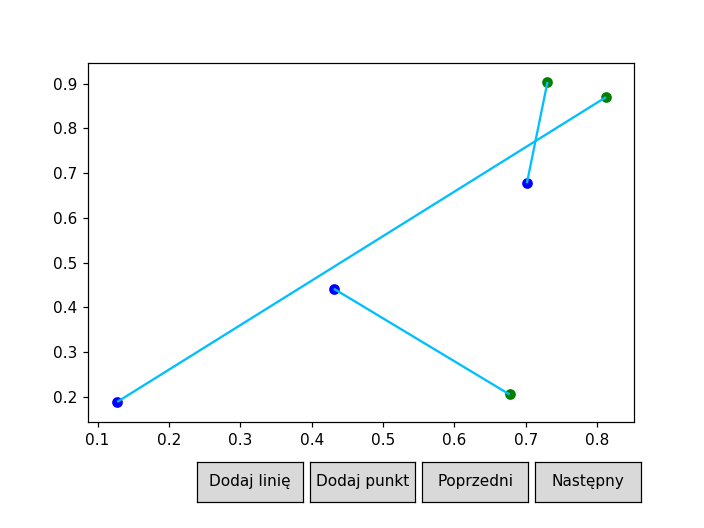

In [35]:
visualiser = Visualiser()

res = get_intersections(linesCollection_to_lines(plot1.get_added_lines()), visualiser)
print(len(res))
print(res)

plota = Plot(visualiser.get_scenes())
plota.draw()

10
[(633386.4239766524, 933247.5377461378), (273409.1840291701, 574499.8334166233), (687679.8153396426, 943133.1988198602), (977748.033343375, 995948.3945454711), (941188.9788298957, 400677.04214525595), (465308.8207397003, 319893.2496201036), (599036.4310527577, 899014.8704058912), (459260.69263530755, 829447.6716643774), (503226.9251884969, 909548.2870962255), (475303.8807966216, 348034.7295897384)]


<IPython.core.display.Javascript object>


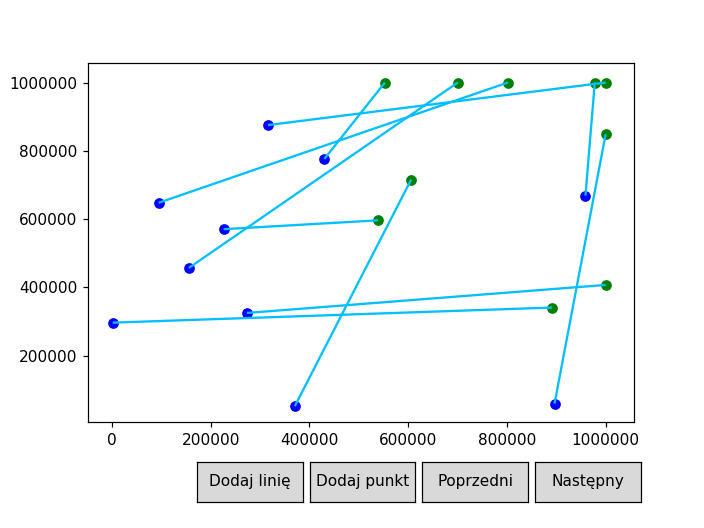

In [34]:
visualiser = Visualiser()

res = get_intersections(lines, visualiser)
print(len(res))
print(res)

plota = Plot(visualiser.get_scenes())
plota.draw()